In [1]:
# Data Processing Imports
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Logger Imports
import time
import logging
import sys
from logging.handlers import TimedRotatingFileHandler

# Model Specific Imports
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

# Visulaization and metrics
from sklearn.metrics import plot_confusion_matrix

In [2]:

FORMATTER = logging.Formatter("%(asctime)s —  %(levelname)s — %(message)s")
LOG_FILE = "LR.log"

def get_console_handler():
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(FORMATTER)
    return console_handler

def get_file_handler():
    file_handler = TimedRotatingFileHandler(LOG_FILE, when='midnight')
    file_handler.setFormatter(FORMATTER)
    return file_handler

def get_logger(logger_name):
    logger = logging.getLogger(logger_name)
    
    if (logger.hasHandlers()): # important as removes duplicate loggers (and thus duplicate log entries)
        logger.handlers.clear()
    logger.setLevel(logging.DEBUG) # better to have too much log than not enough
    logger.addHandler(get_console_handler())
    logger.addHandler(get_file_handler())
    # with this pattern, it's rarely necessary to propagate the error up to parent
    logger.propagate = False
    return logger

logger = get_logger("LR")

In [3]:
Categories_Durum=['CFP-CK1','CFP-CK2'] # [Infected, Healthy]
Categories_Bread=['CFP-CK3','CFP-CK4'] # [Infected, Healthy]
Categories_Test=['CFP-B179','CFP-B223'] # 39/103 or 37.8% infected; 21/105 or 20% infected

All_Categories = [Categories_Durum, Categories_Bread,Categories_Test]

datadir='/student/sch923/Thesis/data/test_wheat_2021/Wheat/TestSamples' 
#path which contains all the categories of images

In [4]:
flat_arr, target_arr=[],[]

# creating species specific data sets
for Categories in All_Categories:
    flat_arr.append(list())
    target_arr.append(list())
    for i in Categories:
        logger.info(f'loading category: {i}')    
        path=os.path.join(datadir,i) 
        image_count = 0
        for img in os.listdir(path):  
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(150,150,3))  
            flat_arr[len(flat_arr)-1].append(img_resized.flatten())

            if i in Categories_Test:
                target_arr[len(flat_arr)-1].append(0) # As only % infection is known, all are assumed to be infected
            else:
                target_arr[len(flat_arr)-1].append(Categories.index(i))
            image_count += 1
        logger.info(f'loaded category: {i} successfully, found {image_count} images')

2021-06-18 13:59:49,374 —  INFO — loading category: CFP-CK1
2021-06-18 13:59:55,519 —  INFO — loaded category: CFP-CK1 successfully, found 43 images
2021-06-18 13:59:55,521 —  INFO — loading category: CFP-CK2
2021-06-18 14:00:02,382 —  INFO — loaded category: CFP-CK2 successfully, found 48 images
2021-06-18 14:00:02,385 —  INFO — loading category: CFP-CK3
2021-06-18 14:00:05,830 —  INFO — loaded category: CFP-CK3 successfully, found 24 images
2021-06-18 14:00:05,832 —  INFO — loading category: CFP-CK4
2021-06-18 14:00:10,261 —  INFO — loaded category: CFP-CK4 successfully, found 31 images
2021-06-18 14:00:10,263 —  INFO — loading category: CFP-B179
2021-06-18 14:00:25,018 —  INFO — loaded category: CFP-B179 successfully, found 103 images
2021-06-18 14:00:25,021 —  INFO — loading category: CFP-B223
2021-06-18 14:00:38,768 —  INFO — loaded category: CFP-B223 successfully, found 96 images


In [5]:
list_arr_fun = lambda l : np.array(l)
flat_data=list(map(list_arr_fun, flat_arr))
target=list(map(list_arr_fun, target_arr))

df_Durum=pd.DataFrame(flat_data[0])
df_Bread=pd.DataFrame(flat_data[1])
df_Complete=pd.DataFrame(np.append(flat_data[0], flat_data[1], axis=0))
df_Test=pd.DataFrame(flat_data[2])

df_Durum['Target']=target[0]
df_Bread['Target']=target[1]
df_Complete['Target']=np.append(target[0], target[1], axis=0)
df_Test['Target']=target[2]

x_Durum=df_Durum.iloc[:,:-1] #input data 
y_Durum=df_Durum.iloc[:,-1] #output data

x_Bread=df_Bread.iloc[:,:-1] #input data 
y_Bread=df_Bread.iloc[:,-1] #output data

x_Complete=df_Complete.iloc[:,:-1] #input data 
y_Complete=df_Complete.iloc[:,-1] #output data

x_Test=df_Complete.iloc[:,:-1] #input data 
y_Test=df_Complete.iloc[:,-1] #output data


In [13]:
# Data Splitting
logger.info('======= Start Of Data Split =======')
x_train_Durum,x_test_Durum,y_train_Durum,y_test_Durum=train_test_split(x_Durum,y_Durum,test_size=0.20,random_state=77,stratify=y_Durum)
logger.info('Durum Splitted Successfully')
x_train_Bread,x_test_Bread,y_train_Bread,y_test_Bread=train_test_split(x_Bread,y_Bread,test_size=0.20,random_state=77,stratify=y_Bread)
logger.info('Bread Splitted Successfully')
x_train_Complete,x_test_Complete,y_train_Complete,y_test_Complete=train_test_split(x_Complete,y_Complete,test_size=0.20,random_state=77,stratify=y_Complete)
logger.info('Complete Splitted Successfully')
x_test_Test,_,y_test_Test,_=train_test_split(x_Test,y_Test,test_size=0.20,random_state=77,stratify=y_Test)
logger.info('Test Splitted Successfully')
logger.info('======= End Of Data Split =======\n')

2021-06-18 14:25:22,499 —  INFO — ======= Start Of Data Split =======
2021-06-18 14:25:22,525 —  INFO — Durum Splitted Successfully
2021-06-18 14:25:22,552 —  INFO — Bread Splitted Successfully
2021-06-18 14:25:22,587 —  INFO — Complete Splitted Successfully
2021-06-18 14:25:22,619 —  INFO — Test Splitted Successfully
2021-06-18 14:25:22,620 —  INFO — ======= End Of Data Split =======



In [7]:
def modelTrainer(model, x_train, y_train, model_name, method_name):
    logger.info(f"Starting to train {method_name} model...")
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    logger.info(f"The {model_name} model trained in: {str(end - start)} seconds")

In [8]:
# Logistic Regression Models

logger.info('======= Start Of Logistic Regression Model Generation =======')
LogR_param_grid={'penalty':['l2'], 'C':[0.1,1,10,100], 'max_iter':[1024], 'solver': ['lbfgs'] } 
LogR_model_Durum=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Bread=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Complete=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)

modelTrainer(LogR_model_Durum, x_train_Durum, y_train_Durum, "Durum", "LogR")
modelTrainer(LogR_model_Bread, x_train_Bread, y_train_Bread, "Bread", "LogR")
modelTrainer(LogR_model_Complete, x_train_Complete, y_train_Complete, "Complete", "LogR")


2021-06-18 14:00:39,169 —  INFO — ======= Start Of Logistic Regression Model Generation =======
2021-06-18 14:00:39,170 —  INFO — Starting to train LogR model...
2021-06-18 14:00:57,238 —  INFO — The Durum model trained in: 18.06664204597473 seconds
2021-06-18 14:00:57,243 —  INFO — Starting to train LogR model...
2021-06-18 14:01:12,321 —  INFO — The Bread model trained in: 15.075881242752075 seconds
2021-06-18 14:01:12,325 —  INFO — Starting to train LogR model...
2021-06-18 14:01:42,085 —  INFO — The Complete model trained in: 29.758492946624756 seconds


In [9]:
# SVM Models

logger.info('======= Start Of SVM Model Generation =======')
SVM_param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
SVM_model_Durum=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Bread=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Complete=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)

modelTrainer(SVM_model_Durum, x_train_Durum, y_train_Durum, "Durum", "SVM")
modelTrainer(SVM_model_Bread, x_train_Bread, y_train_Bread, "Bread", "SVM")
modelTrainer(SVM_model_Complete, x_train_Complete, y_train_Complete, "Complete", "SVM")



2021-06-18 14:01:42,105 —  INFO — ======= Start Of SVM Model Generation =======
2021-06-18 14:01:42,106 —  INFO — Starting to train SVM model...
2021-06-18 14:01:58,363 —  INFO — The Durum model trained in: 16.255311965942383 seconds
2021-06-18 14:01:58,365 —  INFO — Starting to train SVM model...
2021-06-18 14:02:06,768 —  INFO — The Bread model trained in: 8.402727127075195 seconds
2021-06-18 14:02:06,769 —  INFO — Starting to train SVM model...
2021-06-18 14:02:38,553 —  INFO — The Complete model trained in: 31.781675815582275 seconds


In [10]:
# K Nearest Neighbors Models

logger.info('======= Start Of K Nearest Neighbors Model Generation =======')
KNN_param_grid={'n_neighbors':[5], 'weights':['uniform', 'distance']}
KNN_model_Durum=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Bread=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Complete=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)

modelTrainer(KNN_model_Durum, x_train_Durum, y_train_Durum, "Durum", "KNN")
modelTrainer(KNN_model_Bread, x_train_Bread, y_train_Bread, "Bread", "KNN")
modelTrainer(KNN_model_Complete, x_train_Complete, y_train_Complete, "Complete", "KNN")


2021-06-18 14:02:38,573 —  INFO — ======= Start Of K Nearest Neighbors Model Generation =======
2021-06-18 14:02:38,575 —  INFO — Starting to train KNN model...
2021-06-18 14:02:39,766 —  INFO — The Durum model trained in: 1.1902101039886475 seconds
2021-06-18 14:02:39,768 —  INFO — Starting to train KNN model...
2021-06-18 14:02:40,964 —  INFO — The Bread model trained in: 1.1946742534637451 seconds
2021-06-18 14:02:40,965 —  INFO — Starting to train KNN model...
2021-06-18 14:02:42,209 —  INFO — The Complete model trained in: 1.2423501014709473 seconds


In [12]:
# Random Forest Models

logger.info('======= Start Of Random Forest Model Generation =======')
RanF_param_grid={'n_estimators':[100], 'criterion': ['gini', 'entropy']}
RanF_model_Durum=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Bread=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Complete=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)

modelTrainer(RanF_model_Durum, x_train_Durum, y_train_Durum, "Durum", "RanF")
modelTrainer(RanF_model_Bread, x_train_Bread, y_train_Bread, "Bread", "RanF")
modelTrainer(RanF_model_Complete, x_train_Complete, y_train_Complete, "Complete", "RanF")

2021-06-18 14:07:08,330 —  INFO — ======= Start Of Random Forest Model Generation =======
2021-06-18 14:07:08,333 —  INFO — Starting to train RanF model...
2021-06-18 14:07:11,358 —  INFO — The Durum model trained in: 3.0242466926574707 seconds
2021-06-18 14:07:11,359 —  INFO — Starting to train RanF model...
2021-06-18 14:07:13,563 —  INFO — The Bread model trained in: 2.2026591300964355 seconds
2021-06-18 14:07:13,564 —  INFO — Starting to train RanF model...
2021-06-18 14:07:16,295 —  INFO — The Complete model trained in: 2.7300124168395996 seconds


Logistic Regression confusion matrix
[[0.88888889 0.11111111]
 [0.1        0.9       ]]
Logistic Regression confusion matrix
[[0.8        0.2       ]
 [0.16666667 0.83333333]]
Logistic Regression confusion matrix
[[0.85714286 0.14285714]
 [0.0625     0.9375    ]]
Logistic Regression confusion matrix
[[0.9245283  0.0754717 ]
 [0.03174603 0.96825397]]
Logistic Regression confusion matrix
[[0.88888889 0.11111111]
 [0.1        0.9       ]]
Logistic Regression confusion matrix
[[1. 0.]
 [0. 1.]]
Logistic Regression confusion matrix
[[0.92857143 0.07142857]
 [0.         1.        ]]
Logistic Regression confusion matrix
[[0.90566038 0.09433962]
 [0.15873016 0.84126984]]
Logistic Regression confusion matrix
[[1. 0.]
 [0. 1.]]
Logistic Regression confusion matrix
[[1. 0.]
 [0. 1.]]
Logistic Regression confusion matrix
[[0.85714286 0.14285714]
 [0.         1.        ]]
Logistic Regression confusion matrix
[[1. 0.]
 [0. 1.]]
Support Vector Machine confusion matrix
[[1. 0.]
 [0. 1.]]
Support Vecto

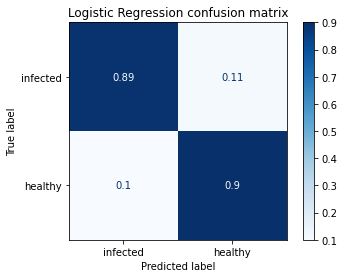

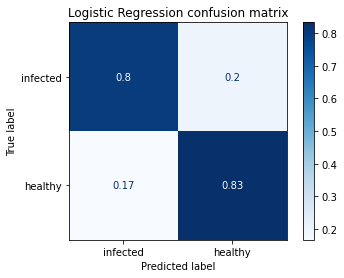

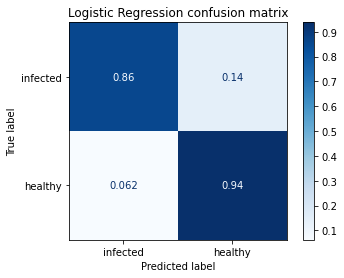

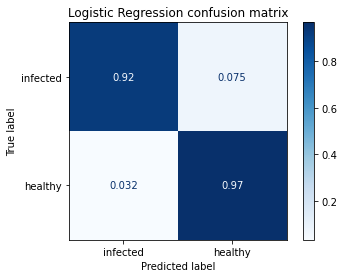

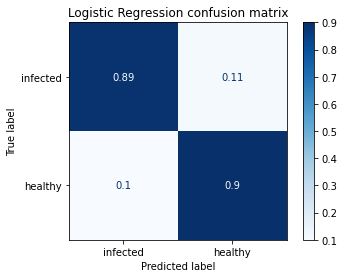

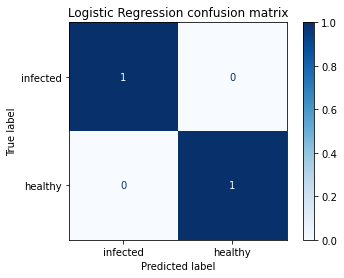

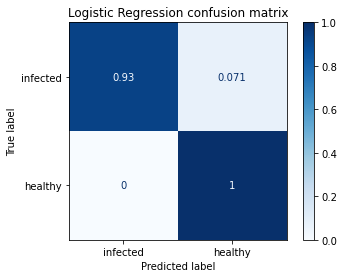

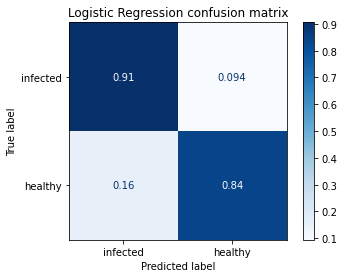

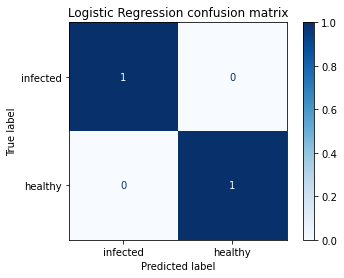

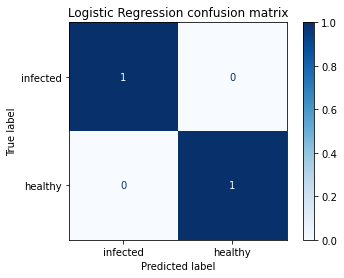

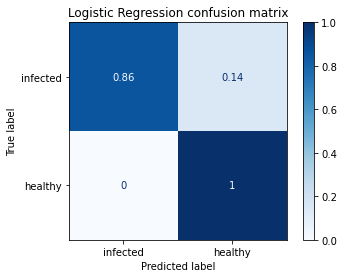

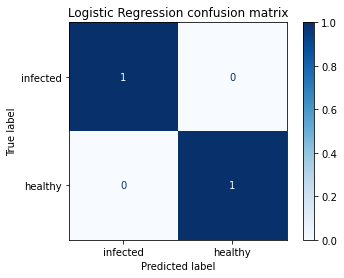

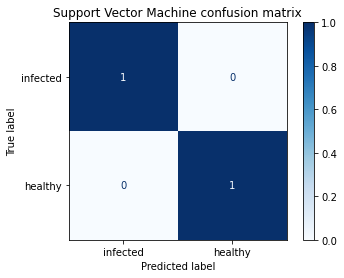

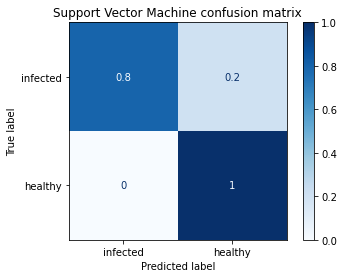

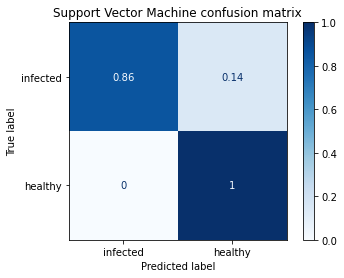

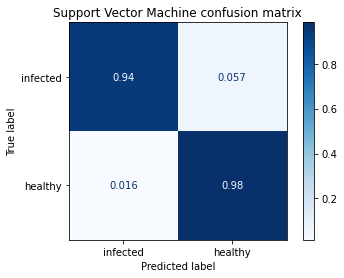

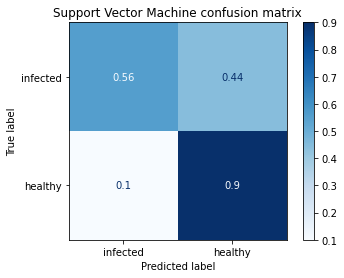

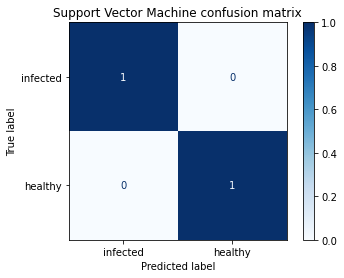

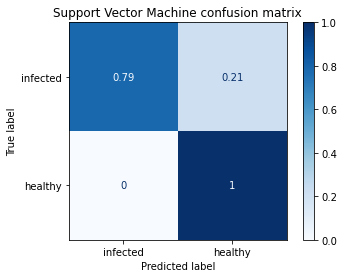

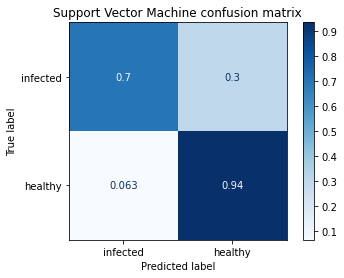

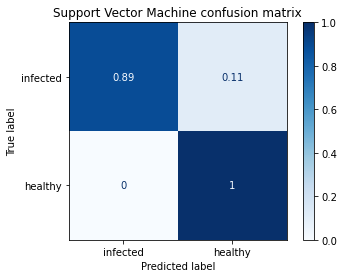

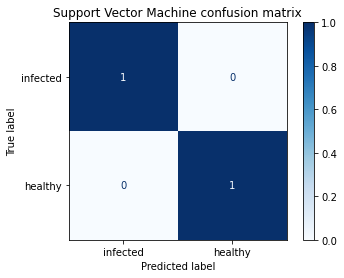

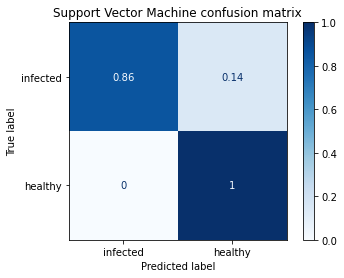

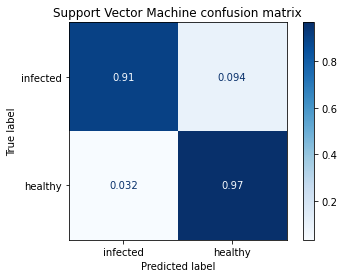

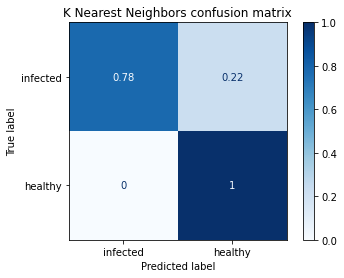

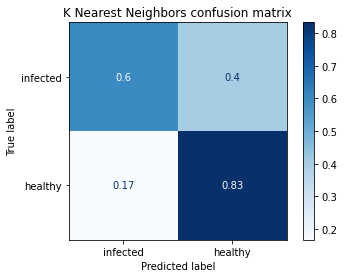

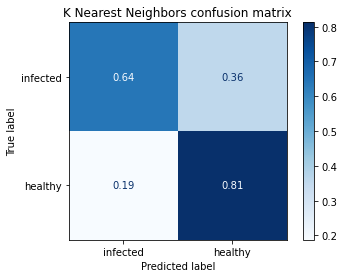

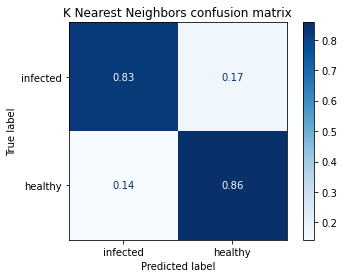

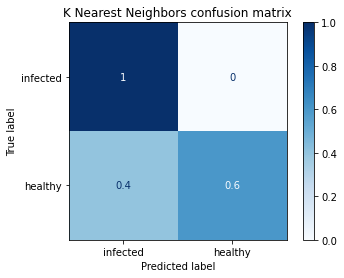

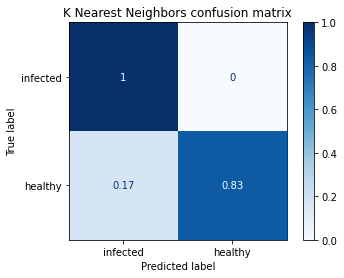

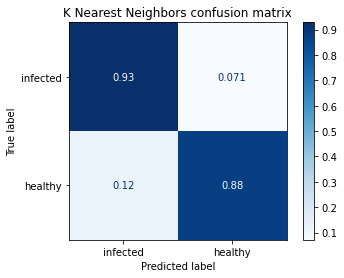

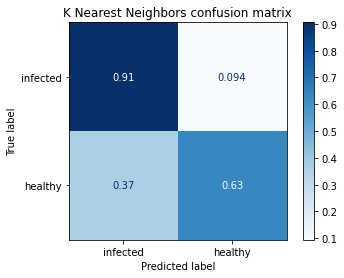

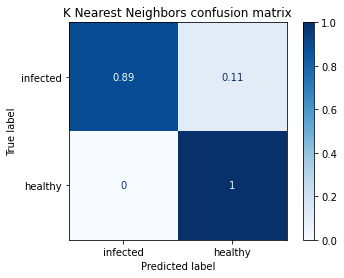

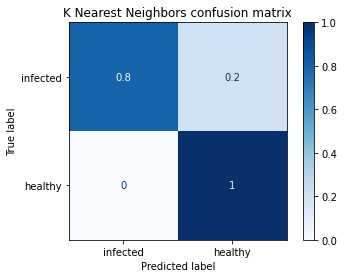

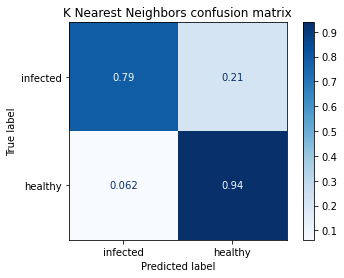

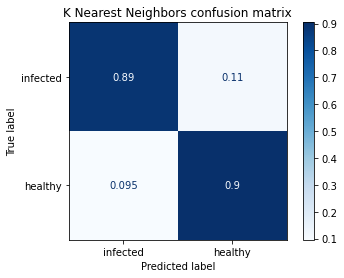

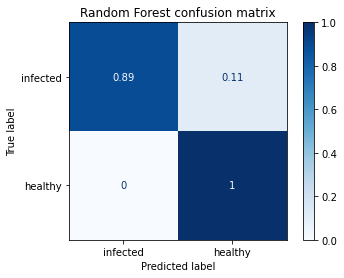

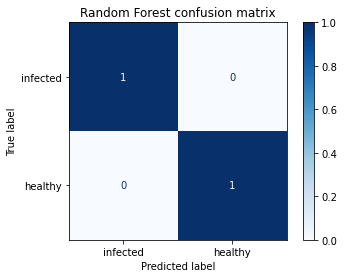

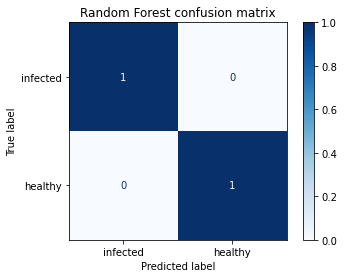

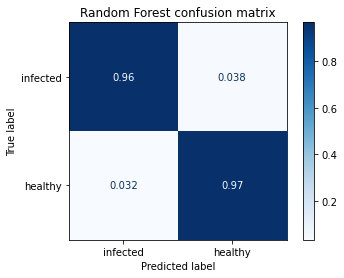

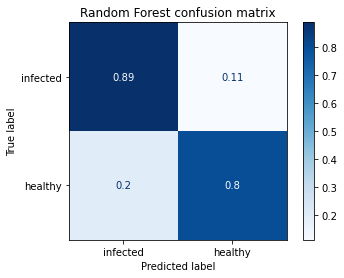

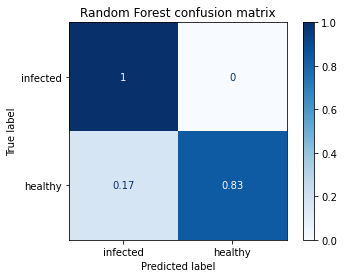

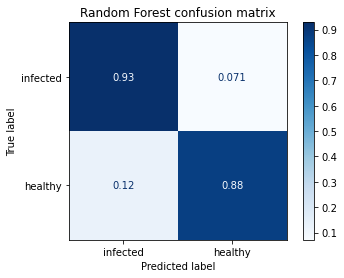

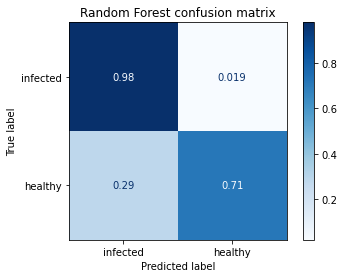

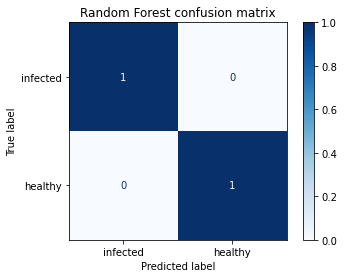

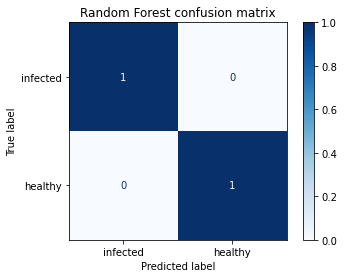

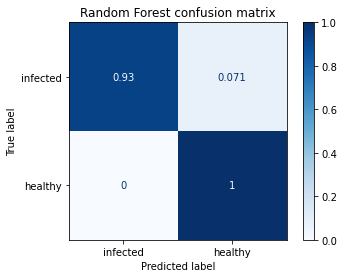

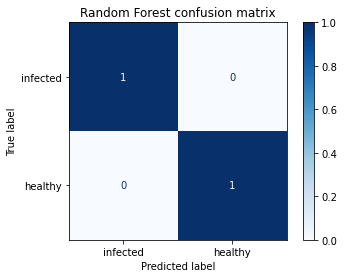

In [18]:
# Generation of confusion matrix for all models

Model_Types = ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Random Forest']
Models = [ [LogR_model_Durum, LogR_model_Bread, LogR_model_Complete], [SVM_model_Durum, SVM_model_Bread, SVM_model_Complete], [KNN_model_Durum, KNN_model_Bread, KNN_model_Complete], [RanF_model_Durum, RanF_model_Bread, RanF_model_Complete]]
Model_Labels = ['Durum', 'Bread', 'Complete']
Test_Sets = [(x_test_Durum, y_test_Durum), (x_test_Bread, y_test_Bread), (x_test_Complete, y_test_Complete), (x_test_Test, y_test_Test)]
Data_Set_Label = ['Durum', 'Bread', 'Complete', 'Test']


for type, class_list in zip(Model_Types, Models):
    for classifier, classifier_label in zip(class_list, Model_Labels):
        for data_set, data_set_label in zip(Test_Sets, Data_Set_Label):
            disp = plot_confusion_matrix(classifier, data_set[0], data_set[1],
                                        display_labels=['infected', 'healthy'],
                                        cmap=plt.cm.Blues,
                                        normalize='true')
            disp.ax_.set_title(f"{type} Confusion Matrix ({classifier_label} Model x {data_set_label} Data)")

            print(f"{type} Confusion Matrix ({classifier_label} Model x {data_set_label} Data)")
            print(disp.confusion_matrix)
